In [1]:
import joblib
import numpy as np
import joblib
import numpy as np
import yaml
import utilities as ut 
import opt_tools as optools

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'slc'

In [3]:
all_data   = ut.load_all_data(experiment)
with open('configs/optimization_hyperparams.yaml', 'r') as f:
    hyperparams = yaml.safe_load(f)

all_data['experiment_name'] = experiment

# 2. Prepare and save the cross-validation folds
Dll_obs     = all_data['LLmodel']['data'][None]
folds_path  = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams['k_folds'], hyperparams['seed'], folds_path)

Data loaded for 'slc'.
Created and saved 2 folds to 'data/slc/cv_folds.pkl'



--- Starting Cross-Validation for Fold 1/2 ---
  - Training for ε=δ = 2
28


 60%|██████    | 3/5 [00:00<00:00,  6.80it/s]

Epoch 0: Objective = 3.0134, Cond. Num = 2.73
Epoch 1: Objective = -0.6629, Cond. Num = 2.68
Epoch 2: Objective = -1.1525, Cond. Num = 2.64


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]

Epoch 3: Objective = -1.1562, Cond. Num = 2.61
Epoch 4: Objective = -1.1677, Cond. Num = 2.58

--- Generating final run summary plot ---


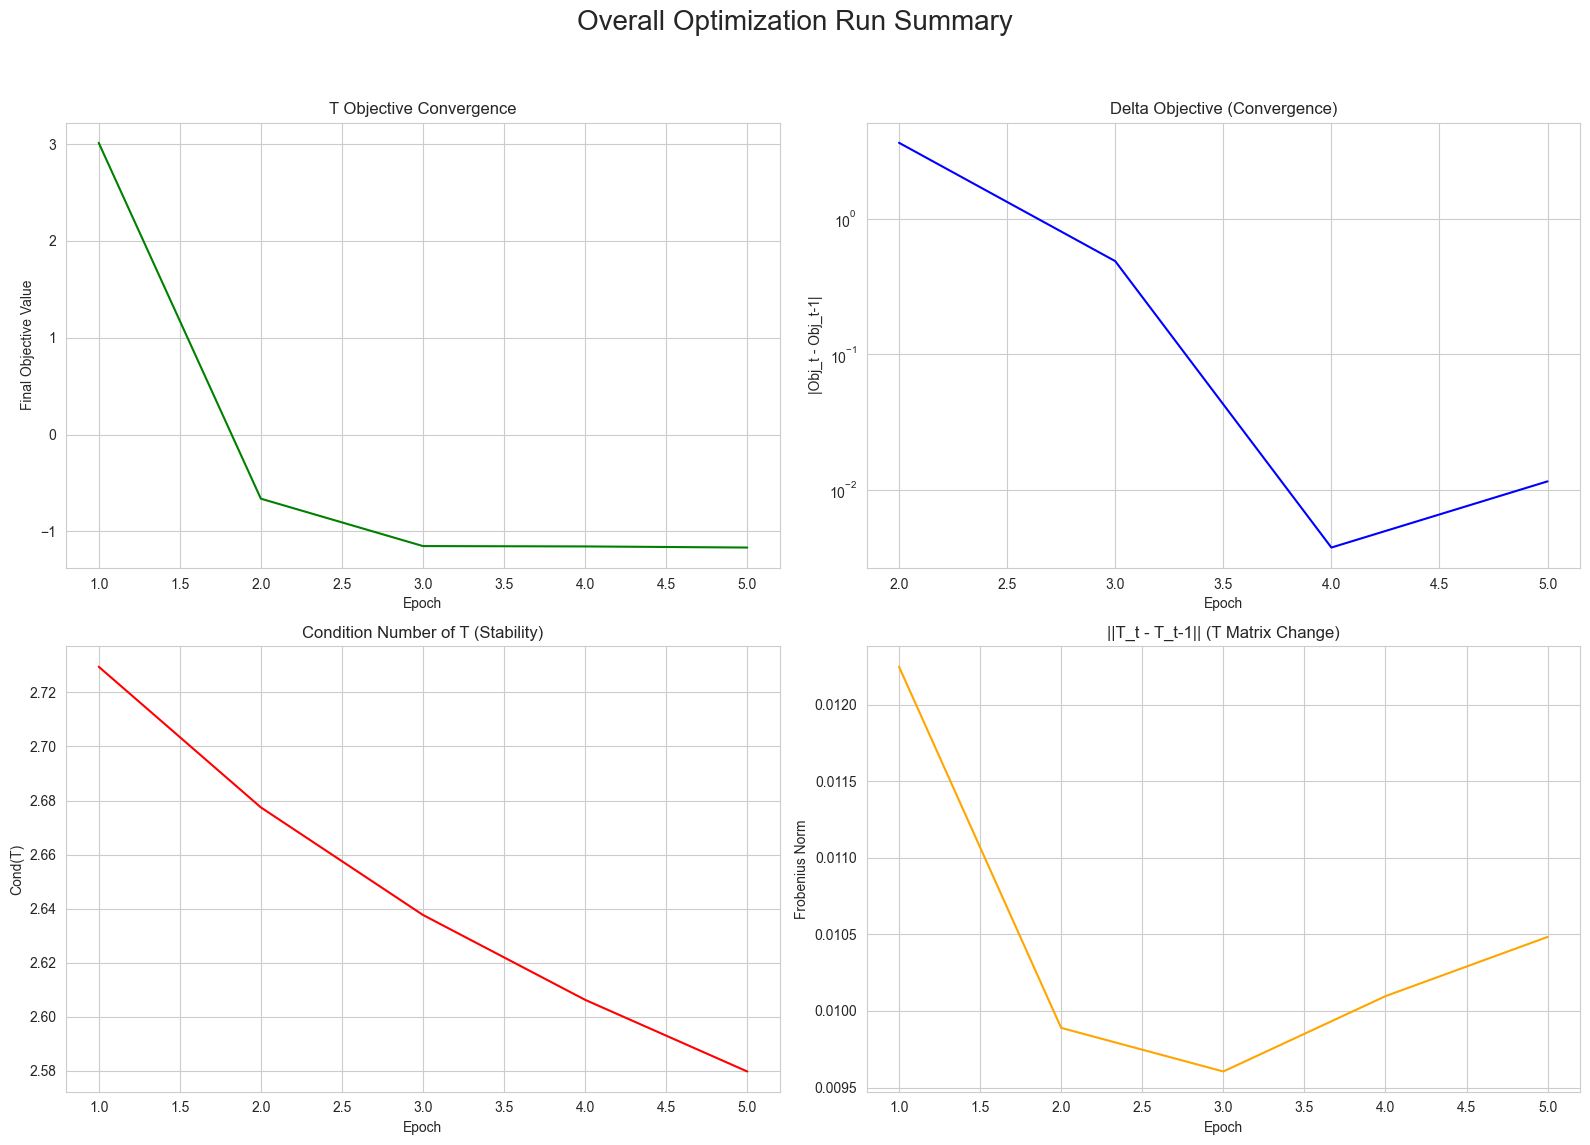


--- Starting Cross-Validation for Fold 2/2 ---
  - Training for ε=δ = 2
28


 40%|████      | 2/5 [00:00<00:00, 10.69it/s]

Epoch 0: Objective = 3.0134, Cond. Num = 2.73
Epoch 1: Objective = -0.6629, Cond. Num = 2.68
Epoch 2: Objective = -1.1525, Cond. Num = 2.64


100%|██████████| 5/5 [00:00<00:00, 10.58it/s]

Epoch 3: Objective = -1.1562, Cond. Num = 2.61
Epoch 4: Objective = -1.1677, Cond. Num = 2.58

--- Generating final run summary plot ---


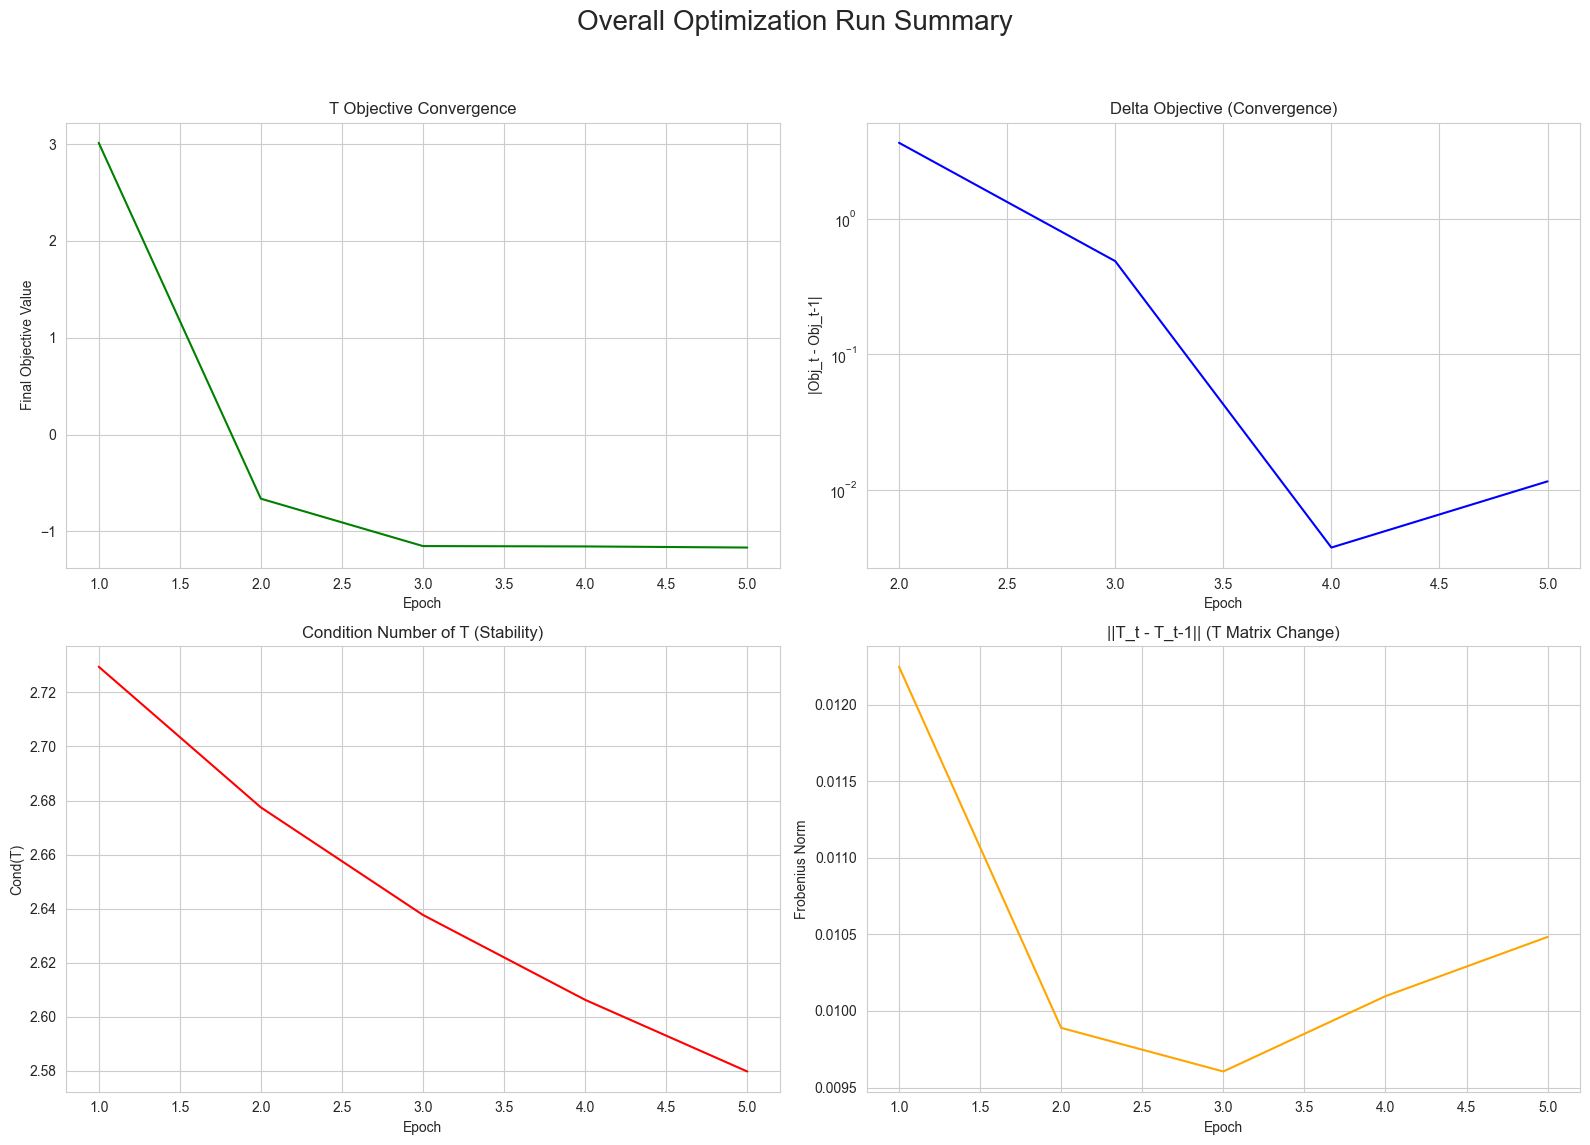



--- Optimization Complete ---
Results have been stored in the 'cv_results' dictionary with a nested structure.


In [4]:
# --- The Main Optimization and Evaluation Loop ---
# 1. Initialize an empty DICTIONARY to store all results
cv_results = {}

# 2. Outer Loop: Iterate through each cross-validation fold
for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Cross-Validation for Fold {i+1}/{len(saved_folds)} ---")
    
    # Create a new sub-dictionary for the current fold
    fold_key = f'fold_{i}'
    cv_results[fold_key] = {}
    
    # Determine the fold-specific radius bound
    train_n = len(fold_info['train'])
    ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    eps_delta_values = [2]#[ll_bound, 1]#, 2, 4, 8]

    # 3. Inner Loop: Iterate through each hyperparameter value
    for eps_delta in eps_delta_values:
        print(f"  - Training for ε=δ = {eps_delta}")

        # Assemble parameters for this specific run
        params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, hyperparams)
        params_for_this_run['theta_hatL']['radius'] = eps_delta
        params_for_this_run['theta_hatH']['radius'] = eps_delta
        
        print(len(params_for_this_run))
        # Prepare arguments for the optimization function
        erica_args = params_for_this_run.copy()
        erica_args.pop('k_folds', None)
        
        # Run the optimization
        trained_params, trained_T = optools.run_erica_optimization(**erica_args)
        
        # 4. Store the results in the NESTED dictionary
        hyperparam_key = f'eps_delta_{eps_delta}'
        cv_results[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'test_indices': fold_info['test'] 
        }

print("\n\n--- Optimization Complete ---")
print("Results have been stored in the 'cv_results' dictionary with a nested structure.")

### 2. GRADCA optimization

In [ ]:
params_Lenrico, T_enrico = oput.run_erica_optimization(**{**opt_params_erica, 'robust_L': False, 'robust_H': False})

In [30]:
diroca_train_results['T_0.00'] = {
                                'optimization_params': params_Lenrico,
                                'T_matrix': T_enrico
                            }

### 3. BARYCA optimization

In [31]:
projection_method = 'svd'
initialization = 'avg'
autograd = False
seed = seed
max_iter = max_iter
tol = tol
display_results = False

In [32]:
opt_params_bary =  {
                    'theta_L': theta_hatL,
                    'theta_H': theta_hatH,
                    'LLmodels': LLmodels,
                    'HLmodels': HLmodels,
                    'Ill': Ill,
                    'Ihl': Ihl,
                    'projection_method': projection_method,
                    'initialization': initialization,
                    'autograd': autograd,
                    'seed': seed,
                    'max_iter': max_iter,
                    'tol': tol,
                    'display_results': display_results
                    }

In [33]:
params_bary, T_bary = oput.barycentric_optimization(**opt_params_bary)

In [34]:
diroca_train_results['T_b'] = {
                                'optimization_params': params_bary,
                                'T_matrix': T_bary
                            }

## Save the results

In [ ]:
joblib.dump(diroca_train_results, f"data/{experiment}/diroca_train_results.pkl")